# Roundtrip Latency
What is the capture and playback latency of the sound system running on the JACK server?

## Experimental overview
In order to test roundtrip latency

## Results summary

sample rate (Hz) | frames/period | periods/buffer | calc. roundtrip latency (ms) | exp. roundtrip latency (ms) | Xruns?
----- | --- | -- | ---- | ---- | ---
48000 | 128 | 2  |  5.3 | 12.4 | YES
48000 | 256 | 2  | 10.7 | 15.1 | NO
48000 | 512 | 2  | 21.3 | 32.2 | NO


Notes:
1. The theoretical roundtrip latency is a combination of the capture latency and playback latency. Each of these, in turn, depends on the buffer size and sampling rate: $\text{latency} = \frac{\text{buffer size}}{\text{sampling rate}}$. See [here](https://alsa-project.org/wiki/FramesPeriods) for more details.
2. The speaker and microphone were spaced 10 cm apart. Because the speed of sound in room conditions is 343 m/s, then the time for sound to propagate from the speaker to the microphone is approximately $\frac{10 \text{ cm}}{343 \text{ m/s}} = 0.29 \text{ ms}$. Because this is on the order of error for our setup, we can ignore sound propagation when estimating our roundtrip latency.

## Initial setup

### Imports

In [1]:
import wave
from scipy.io import wavfile
from scipy.signal import butter, lfilter, freqz, hilbert
from scipy import fft, ifft
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

### Functions

In [40]:
# From: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_design(*freq, btype='band', fs=1.0, order=5):
    nyq = 0.5 * fs
    freq = [f/nyq for f in freq]
    b, a = butter(order, freq, btype=btype)
    return b, a

def butter_filter(data, *freq, btype='band', fs=1.0, order=5):
    b, a = butter_design(*freq, btype=btype, fs=fs, order=order)
    y = lfilter(b, a, data)
    return y

## Load audio files

### Settings

In [67]:
# Filenames
filename_out = '/Users/jbwebb/Desktop/audio/LeftSpeaker03.wav'
filename_in = '/Users/jbwebb/Desktop/audio/Microphone03.wav'

### Preprocess files

Output start minus input start: 0.0030 seconds (145 samples)


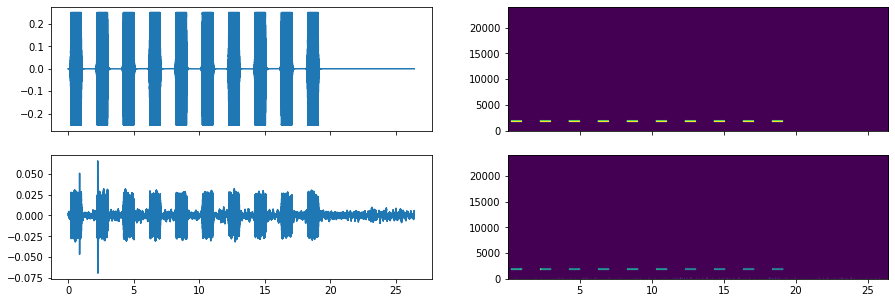

In [80]:
# Load audio files
fs_out, wf_out = wavfile.read(filename_out)
fs_in, wf_in = wavfile.read(filename_in)

# Downsample to lowest sampling frequency
fs = min(fs_out, fs_in)
if fs_out < fs_in:
    F = interp1d(np.arange(len(wf_in)), wf_in, kind='quadratic')
    wf_in = F(np.linspace(0, len(wf_in)-1, (fs_out/fs_in)*len(wf_in)))
elif fs_in < fs_out:
    F = interp1d(np.arange(len(wf_out)), wf_out, kind='quadratic')
    wf_out = F(np.linspace(0, len(wf_out)-1, (fs_in/fs_out)*len(wf_out)))

# Align timestamps
with open(filename_out + '.tme', 'r') as f:
    ts_out = float(f.readline().strip())
with open(filename_in + '.tme', 'r') as f:
    ts_in = float(f.readline().strip())

t_diff = ts_out - ts_in
n_diff = int(abs(t_diff)*fs)
print('Output start minus input start: {:.4f} seconds ({} samples)'
      .format(t_diff, n_diff))

# Trim audio in beginning to align at time zero
if ts_out > ts_in:
    wf_in = wf_in[n_diff:]
elif ts_in > ts_out:
    wf_out = wf_out[n_diff:]
    
# Trim audio at end to make same size
wf_out = wf_out[:min(len(wf_out), len(wf_in))]
wf_in = wf_in[:min(len(wf_out), len(wf_in))]

# Plot waveforms
fig, ax = plt.subplots(2, 2, figsize=(15, 5), sharex='col')

_ = ax[0, 0].plot(np.arange(len(wf_out))/fs, wf_out)
_ = ax[0, 1].specgram(wf_out, Fs=fs, NFFT=256, Fc=0, scale='linear')

_ = ax[1, 0].plot(np.arange(len(wf_in))/fs, wf_in)
_ = ax[1, 1].specgram(wf_in, Fs=fs, NFFT=256, Fc=0, scale='linear')

### Filter audio
Let's filter out some of the high frequency noise

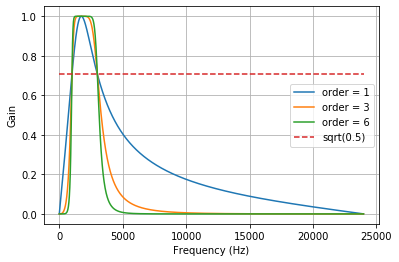

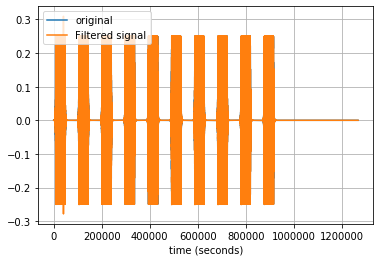

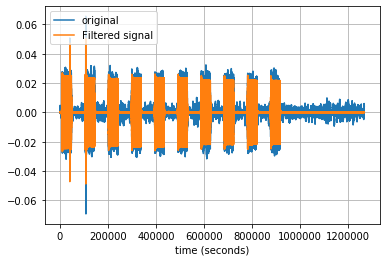

In [81]:
# From: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

# Sample rate and desired cutoff frequencies (in Hz).
lowcut = 1000.0
highcut = 3000.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 3, 6]:
    b, a = butter_design(lowcut, highcut, fs=fs, order=order, btype='band')
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
plt.figure(2)
plt.plot(wf_out, label='original')
wf_out_filt = butter_filter(wf_out, lowcut, highcut, fs=fs, order=6)
plt.plot(wf_out_filt, label='Filtered signal')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.figure(3)
plt.plot(wf_in, label='original')
wf_in_filt = butter_filter(wf_in, lowcut, highcut, fs=fs, order=6)
plt.plot(wf_in_filt, label='Filtered signal')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()


## Manual inspection

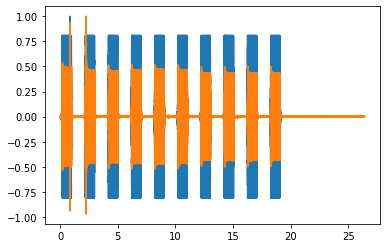

In [82]:
t = np.arange(len(wf_in_filt))/fs
plt.plot(t, 
         wf_out_filt/np.max(wf_out_filt),
         label='out')
plt.plot(t, 
         wf_in_filt/np.max(wf_in_filt),
         label='in')

Let's zoom in on the beginning.

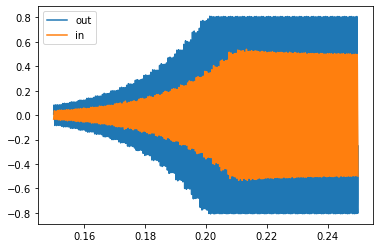

In [83]:
t1 = 0.15
t2 = 0.25
idx_plot = np.argwhere(np.logical_and(t > t1, t < t2))
plt.plot(t[idx_plot], 
         wf_out_filt[idx_plot]/np.max(wf_out_filt),
         label='out')
plt.plot(t[idx_plot], 
         wf_in_filt[idx_plot]/np.max(wf_in_filt),
         label='in')
plt.legend()

Here, it looks like the input signal lags about 10-15 ms behind the output signal. Note the ramping function of the change in sound due to `jackminimix`, which introduces changes in channel gain over time based on the parameter `GAIN_FADE_RATE`.

## Automatic inspection

### Define functions

In [84]:
def cross_correlation(x, y, fs=1.0):
    # Credit: https://dsp.stackexchange.com/a/739
    
    # Zero-pad both inputs
    x_pad = np.hstack([x, np.zeros(len(x))])
    y_pad = np.hstack([y[::-1], np.zeros(len(y))]) # reversed; otherwise, would be convolution
    
    # Compute FFT of inputs
    n_max = min(len(x_pad), len(y_pad)) # in case different lengths
    x_fft = fft(x_pad, n=n_max)
    y_fft = fft(y_pad, n=n_max) 
    
    # Return IFFT of FFT dot product
    corr = ifft(x_fft * y_fft).real
    t = (np.arange(len(corr)) - len(corr)//2) / fs
    
    return t, corr

def find_offset(x, y, 
                fs=1.0,
                t_min=None, 
                t_max=None,
                use_envelope=False,
                plot_results=True):
    """
    Find offset between two audio recordings.
    
    This is the time of the second recording relative to the first. 
    That is, the time t returned is such that: t_2 + t = t_1.
    """
    
    # Compute cross correlation between waveforms
    t, corr = cross_correlation(x, y, fs=fs)
    
    # Find boundaries
    if t_min is None:
        t_min = t[0]
    if t_max is None:
        t_max = t[-1]
    t_range = np.argwhere(np.logical_and(t >= t_min, t <= t_max))
    t = t[t_range]
    corr = corr[t_range]
    
    # Plot results
    if plot_results:
        plt.plot(t, corr)
        
    # Return peak value
    return float(t[np.argmax(corr)])

### Find offset

0.0124375


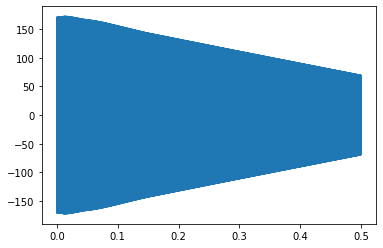

In [86]:
t_offset = find_offset(wf_in_filt, 
                       wf_out_filt, 
                       fs=fs, 
                       t_min=0.0, # because input must lag behind output
                       t_max=0.5,
                       plot_results=True)
print(t_offset)